# Does halo spectroscopy work on an unsaturated source?

If we want to believe halo spectroscopy results on a saturated source, we should first verify that it gives satisfactory results for an *unsaturated* source. Therefore let us look at Phaethon, not expected to be saturated, and try the various optimized weight spectroscopy methods.

First, import everything we need.

In [1]:
import jax.numpy as np
import matplotlib.pyplot as plt
import numpy as onp

import jax 

from astropy.io import fits

from glob import glob

import halospec.objectives as obj

import jaxopt

from matplotlib.widgets import Slider

jax.config.update("jax_enable_x64", True)


%matplotlib inline


In [2]:
# ls ../data/MAST_2023-02-09T2333/JWST/

Which sources did we get in this download?

In [3]:
ddir = '../data/MAST_2023-02-09T2331/JWST/' # unsaturated 
# ddir = '../data/MAST_2023-02-09T2333/JWST/'# saturated
datasets = glob(ddir+'*')
# print(datasets)

# figure out which targets are which
for j, dataset in enumerate(datasets):
    try:
        ifu = glob(dataset+'/*s3d*')
        hdr = fits.getheader(ifu[0])
        name = hdr['OBSLABEL']
        print(j, name)
    except:
        print(j,'--')

0 Didymos/MIRI
1 Didymos/MIRI
2 Didymos/MIRI Background
3 Phaethon/MIRI
4 Didymos/MIRI
5 Didymos/MIRI Background
6 Phaethon/MIRI
7 Phaethon/MIRI
8 Phaethon/MIRI
9 Didymos/MIRI Background
10 Didymos/MIRI
11 Didymos/MIRI Background
12 --


In [4]:
# dataset = ddir + 'jw01244-o024_t003_miri_ch4-shortmediumlong/'

index =  7 # Phaethon
dataset = datasets[index]+'/'
# print(dataset)

ifu = glob(dataset+'*s3d*')
print('IFU Filename',ifu[0])
# print(files)

extracted = glob(dataset+'*x1d*')
print('Extracted Spectrum filename',extracted[0])
extracted_hdr = fits.getheader(extracted[0],ext=1)

hdu = fits.open(ifu[0])
data = fits.getdata(ifu[0])
hdr = fits.getheader(ifu[0])
name = hdr['OBSLABEL']

extracted = glob(dataset+'*x1d*')
extracted_hdr = fits.getheader(extracted[0],ext=1)
extracted_data = fits.getdata(extracted[0],ext=1)
wavels, ext_spec = extracted_data['WAVELENGTH'], extracted_data['FLUX']
ext_spec /= onp.nanmedian(ext_spec)

print('\nTarget:',name)

IFU Filename ../data/MAST_2023-02-09T2331/JWST/jw01245-o004_t001_miri_ch3-shortmediumlong/jw01245-o004_t001_miri_ch3-shortmediumlong_s3d.fits
Extracted Spectrum filename ../data/MAST_2023-02-09T2331/JWST/jw01245-o004_t001_miri_ch3-shortmediumlong/jw01245-o004_t001_miri_ch3-shortmediumlong_x1d.fits

Target: Phaethon/MIRI


# Visualize a slice

Text(0.5, 1.0, 'Zero')

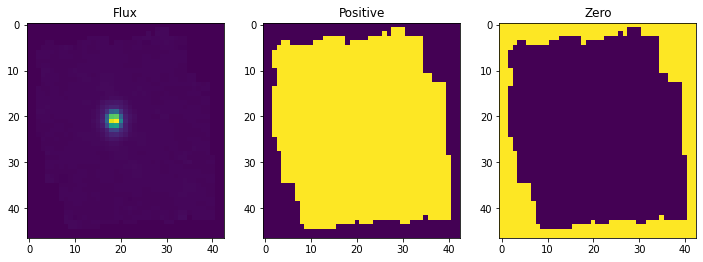

In [5]:
# one frame
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12.0,4.0))

ax1.imshow(data[0,:,:])
ax1.set_title('Flux')

ax2.imshow(data[0,:,:]>0)
ax2.set_title('Positive')

ax3.imshow(data[0,:,:]==0)
ax3.set_title('Zero')

(Interactively explore a slice)

In [6]:
# %matplotlib widget 
# idx0 = 3
# l = plt.imshow(data[idx0])

# axidx = plt.axes([0.25, 0.01, 0.65, 0.03])
# slidx = Slider(axidx, 'index', 0, 9, valinit=idx0, valfmt='%d')

# def update(val):
#     idx = slidx.val
#     l.set_data(data[int(idx)])
#     fig.canvas.draw_idle()
    
# slidx.on_changed(update)

# plt.show()


Text(0.5, 1.0, 'Zero')

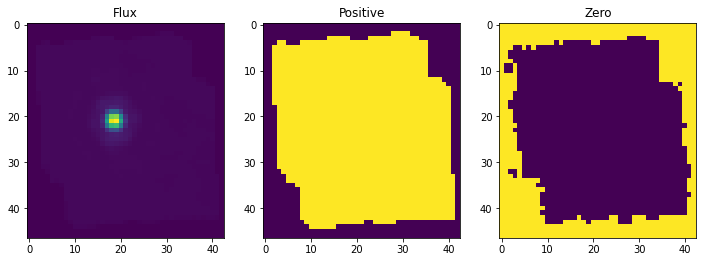

In [7]:
%matplotlib inline

# all frames
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12.0,4.0))

ax1.imshow(onp.median(data,axis=0))
ax1.set_title('Flux')

ax2.imshow(onp.median(data,axis=0)>0)
ax2.set_title('Positive')

ax3.imshow(onp.min(data,axis=0)==0)
ax3.set_title('Zero')

So they are using zero-masking. That's good!

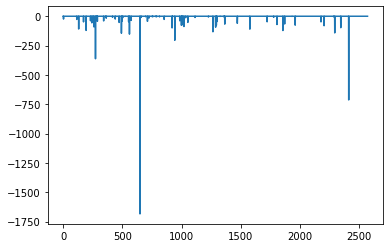

In [8]:
# ravel pixels
ravelled = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]))
plt.plot(onp.min(ravelled,axis=1)) # some frames are badly corrected?

In [9]:
# frame rejection
goodframes = onp.min(ravelled,axis=1)==0

# pixel rejection
goodpix = onp.min(data,axis=0)>0

# censored data
newdata = data[:,goodpix]
newdata = newdata[goodframes]

wavels, ext_spec = wavels[goodframes],ext_spec[goodframes]
print('Shape of censored data in spectra x spaxels:',newdata.shape)

Shape of censored data in spectra x spaxels: (2485, 1150)


Plot some individual spectra, as well as the pipeline and sum:

Text(0.5, 0, 'Wavelength (μm)')

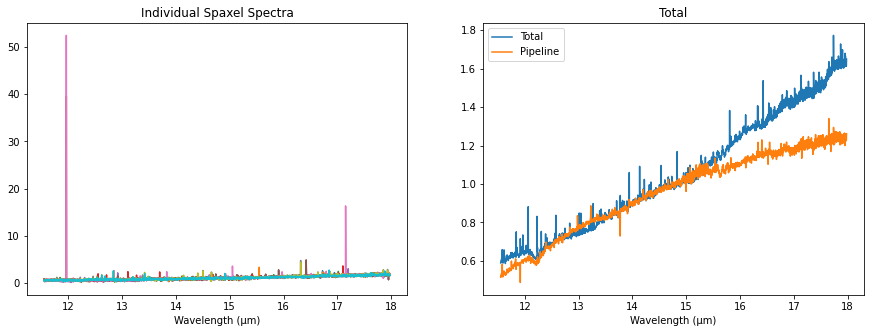

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15.0,5.0))
for j in range(10):
    spec = newdata[:,j]
    ax1.plot(wavels,spec/onp.nanmedian(spec))
ax1.set_title('Individual Spaxel Spectra')
ax1.set_xlabel('Wavelength (μm)')
    
flat = onp.sum(newdata,axis=1)
flat /= onp.nanmedian(flat)
ax2.plot(wavels,flat,label='Total')
ax2.plot(wavels,ext_spec/onp.nanmedian(ext_spec),label='Pipeline')
plt.legend()

ax2.set_title('Total')
ax2.set_xlabel('Wavelength (μm)')

Looks like there are a bunch of bad pixels/frames/something. We will probably do a lot better with improved data cleaning.

# Now let's do a TV-min spectral extraction.

We will compare the classic TV-min algorithm from [White et al, 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.471.2882W/abstract) to L2 and standard-deviation-optimization algorithms. 

In [11]:
from jaxopt import LBFGS
make_spec = obj.make_spec

In [12]:
spaxels = np.array(newdata).T # make it a jax array of the right shape

In [13]:
%%time

# TV-Min - minimize L1 norm of gradient - same as in halo
tvmin = lambda x: obj.tv(x,1,spaxels) # not using lag so setting it to 1 by lambda function

init_params = 1.0*np.ones(newdata.shape[1]) # shape is (wavels,spaxels)

solver = jaxopt.LBFGS(fun=tvmin, maxiter=100)
res = solver.run(init_params)
tv_params, state = res

tv_final = make_spec(tv_params,spaxels)

CPU times: user 5.97 s, sys: 137 ms, total: 6.1 s
Wall time: 6.04 s


In [14]:
%%time

# L2V-Min - minimize L2 norm of gradient, ie maximize smoothness
l2vmin = lambda x: obj.l2v(x,1,spaxels) # not using lag so setting it to 1 by lambda function

init_params = 1.0*np.ones(newdata.shape[1]) # shape is (wavels,spaxels)

solver = jaxopt.LBFGS(fun=l2vmin, maxiter=100)
res = solver.run(init_params)
l2v_params, state = res

l2v_final = make_spec(l2v_params,spaxels)

CPU times: user 4.47 s, sys: 108 ms, total: 4.57 s
Wall time: 4.51 s


In [15]:
%%time
# OWL - from https://github.com/davidwhogg/OWL using standard deviation as the objective. 

owlmin = lambda x: obj.owl(x,spaxels)

init_params = 1.0*np.ones(newdata.shape[1]) # shape is (wavels,spaxels)

solver = jaxopt.LBFGS(fun=owlmin, maxiter=100)
res = solver.run(init_params)
owl_params, state = res

owl_final = make_spec(owl_params,spaxels)

CPU times: user 4.54 s, sys: 106 ms, total: 4.65 s
Wall time: 4.56 s


In [20]:
%%time
# OWL - from https://github.com/davidwhogg/OWL using standard deviation as the objective. 

gpmin = lambda x: obj.gp(x,spaxels,np.array(wavels))

init_params = 1.0*np.ones(newdata.shape[1]) # shape is (wavels,spaxels)

solver = jaxopt.LBFGS(fun=gpmin, maxiter=100)
res = solver.run(init_params)
gp_params, state = res

gp_final = make_spec(gp_params,spaxels)

CPU times: user 9.79 s, sys: 157 ms, total: 9.94 s
Wall time: 9.83 s


In [21]:
# what does a direct sum look like
uniform = make_spec(init_params,spaxels)

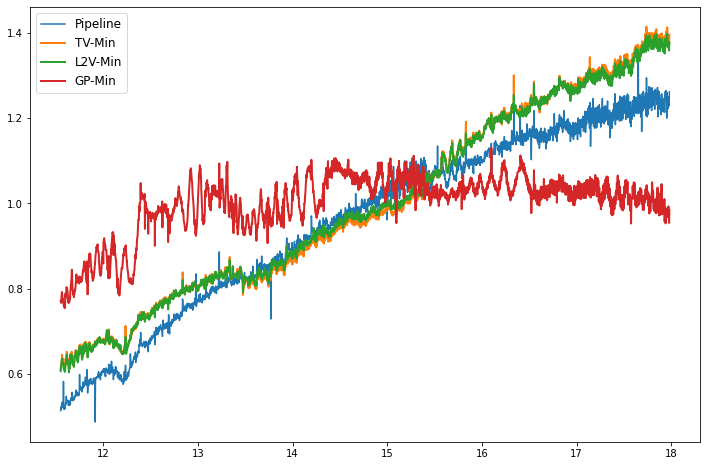

In [22]:
fig = plt.figure(figsize=(12.0,8.0))

plt.plot(wavels,ext_spec/onp.nanmedian(ext_spec),label='Pipeline')


plt.plot(wavels,tv_final,label='TV-Min',lw=2)
plt.plot(wavels,l2v_final,label='L2V-Min',lw=2)
plt.plot(wavels,gp_final,label='GP-Min',lw=2)

# plt.plot(wavels,owl_final,label='OWL',lw=2)
# plt.plot(wavels,uniform,label='Uniform')



plt.legend(fontsize=12)

So the optimized spectra don't look a lot better than with uniform weights, and none of them closely resemble the pipeline spectrum (which may be a feature, not a bug!).

## Visualize the Weight map

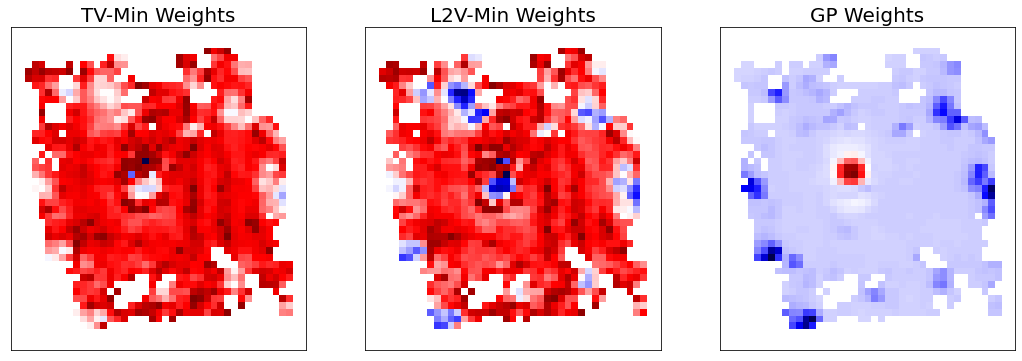

In [23]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))

weightmap = onp.nan*goodpix
weightmap[goodpix] = obj.softmax(tv_params)
ax1.imshow(np.log10(weightmap),cmap=plt.cm.seismic)
ax1.set_title('TV-Min Weights',fontsize=20)

weightmap = onp.nan*goodpix
weightmap[goodpix] = obj.softmax(l2v_params)
ax2.imshow(np.log10(weightmap),cmap=plt.cm.seismic)
ax2.set_title('L2V-Min Weights',fontsize=20)

weightmap = onp.nan*goodpix
weightmap[goodpix] = obj.softmax(gp_params)
ax3.imshow(np.log10(weightmap),cmap=plt.cm.seismic)
ax3.set_title('GP Weights',fontsize=20)

for ax in (ax1,ax2,ax3):
    ax.set_xticks([])
    ax.set_yticks([])

Not sure what to make of this - of the three, the GP has really nailed putting the weights on the target; whereas the others seem to have spread out across the background, but nevertheless match the pipeline better.